<a href="https://colab.research.google.com/github/stellagerantoni/LatentCfMultivariate/blob/main/multivariate_pendigits_with_closesed_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! git clone https://github.com/stellagerantoni/LatentCfMultivariate

In [ ]:
!pip install -q wildboar
!pip install -q scikit-learn
!pip install -q stumpy
!pip install -q fastdtw
!pip install aeon[all_extras]

In [8]:
import logging
import os
import warnings
from argparse import ArgumentParser
from aeon.datasets import load_classification

from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.spatial import distance_matrix
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KDTree, KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from wildboar.datasets import load_dataset
from wildboar.ensemble import ShapeletForestClassifier
from wildboar.explain.counterfactual import counterfactuals
%cd '/content/LatentCfMultivariate'
from _guided import ModifiedLatentCF
from help_functions import *
from keras_models import *

/content/LatentCfMultivariate


In [9]:
os.environ['TF_DETERMINISTIC_OPS'] = '1'
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
RANDOM_STATE = 39

# **ACTUALL CODE**

In [10]:
#Getting the dataset

RANDOM_STATE = 39
X,y = load_classification('PenDigits')
X = X.transpose(0,2,1)
print(f'shape of X = {X.shape}')
print(f'shape of y = {y.shape}')
#print(f'data imformation = {data_information}')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
print(f'shape of X train = {X_train.shape}')
print(f'shape of y train = {y_train.shape}')

shape of X = (10992, 8, 2)
shape of y = (10992,)
shape of X train = (8793, 8, 2)
shape of y train = (8793,)


In [11]:
#Upsample the minority class

unique_classes, class_counts = np.unique(y_train, return_counts=True)
print(f'before: {class_counts}')
X_train,y_train = upsample_minority_multivariate(X_train,y_train)
X,y = upsample_minority_multivariate(X, y)
unique_classes, class_counts = np.unique(y_train, return_counts=True)
print(f'after: {class_counts}')

before: [914 914 915 844 915 844 845 914 844 844]
after: [915 915 915 915 915 915 915 915 915 915]


In [12]:
#Processing and Padding all our data
#Padding needed for autoencoder

n_training,n_timesteps, n_features= X_train.shape

X, trained_scaler =  normalize_multivariate(data=X, n_timesteps=n_timesteps, n_features = n_features)
X_train_processed, trained_scaler =  normalize_multivariate(data=X_train, n_timesteps=n_timesteps, n_features = n_features)
X_test_processed, _ =  normalize_multivariate(data=X_test, n_timesteps=n_timesteps, scaler=trained_scaler, n_features = n_features)

X, padding_size = conditional_pad_multivariate(X)
X_train_processed_padded, padding_size = conditional_pad_multivariate(X_train_processed) # add extra padding zeros if n_timesteps cannot be divided by 4, required for 1dCNN autoencoder structure
X_test_processed_padded, _ = conditional_pad_multivariate(X_test_processed)

n_timesteps_padded = X_train_processed_padded.shape[1]
print(f"Data pre-processed, original #timesteps={n_timesteps}, padded #timesteps={n_timesteps_padded}.")

#check the processing (0,1) min should be min 0 and max should be max 1
print(f"\nmin value = {np.min(X_train)}, max value = {np.max(X_train)}")
print(f"min value normalized = {np.min(X_train_processed)}, max value normalized= {np.max(X_train_processed)}")

#check that padding paddes the right dimention
print(f"\nX_train.shape = {X_train.shape}" )
print(f"X_train_processed_padded.shape = {X_train_processed_padded.shape}")


Data pre-processed, original #timesteps=8, padded #timesteps=8.

min value = 0.0, max value = 100.0
min value normalized = 0.0, max value normalized= 1.0

X_train.shape = (9150, 8, 2)
X_train_processed_padded.shape = (9150, 8, 2)


In [13]:
def extract_two_digits(X,y,n_1,n_2, RANDOM_STATE):
  #get the normal and abnormal label
  #abnormal is the target label for the latentCF++ model
  normal_label = n_1
  abnormal_label = n_2

  #Get the indices
  normal_indices = np.where(y == normal_label)[0]
  abnormal_indices = np.where(y == abnormal_label)[0]

  #Use the indices to get the wanted data points
  X_abnormal = X[abnormal_indices]
  y_abnormal = y[abnormal_indices]

  X_normal = X[normal_indices]
  y_normal = y[normal_indices]

  #stack all the data together again
  X = np.concatenate([X_abnormal,X_normal])
  y = np.concatenate([y_abnormal,y_normal])

  #shuffle them
  X, y = shuffle(X, y, random_state=RANDOM_STATE)

  #iterate over the dataset to make the labels 0 for abnormal and 1 for normal

  for i in range(y.shape[0]):
    if y[i] == n_2:
      y[i]=1
    else:
      y [i]=0

  y = y.astype(int)
  print(f'Class 0 represents number {n_1}. [1.,0.]')
  print(f'Class 1 represents number {n_2}. [0.,1.]\n')

  return X,y

In [14]:
#Get only two classes from the dataset (only too needed for counterfactuals)

X, y = extract_two_digits(X,y,'0','8', RANDOM_STATE)
X_train, y_train = extract_two_digits(X_train_processed_padded,y_train,'0','8', RANDOM_STATE)
X_test, y_test = extract_two_digits(X_test_processed_padded,y_test,'0','8', RANDOM_STATE)

Class 0 represents number 0. [1.,0.]
Class 1 represents number 8. [0.,1.]

Class 0 represents number 0. [1.,0.]
Class 1 represents number 8. [0.,1.]

Class 0 represents number 0. [1.,0.]
Class 1 represents number 8. [0.,1.]



In [15]:
from sklearn.model_selection import train_test_split
X_train,X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train)


In [16]:
#Getting the two forms of labels needed
#-the y_classes (1,0,1,0,...)
#-the y (one hot encoded)

print(f'X_train = {X_train.shape}')
print(f'X_validation = {X_validation.shape}')
print(f'X_test = {X_test.shape}')

y_classes = y
y_train_classes = y_train
y_validation_classes = y_validation
y_test_classes = y_test

from tensorflow.keras.utils import to_categorical
y = to_categorical(y, len(np.unique(y)))
y_train = to_categorical(y_train, len(np.unique(y_train)))
y_validation = to_categorical(y_validation, len(np.unique(y_validation)))
y_test = to_categorical(y_test, len(np.unique(y_test)))

print(f'\ny_train_classes = {y_train_classes.shape}, y_validation_classes = {y_validation_classes.shape}, y_test_classes = {y_test_classes.shape}')
print(f'y_train = {y_train.shape}, y_validation = {y_validation.shape}, y_test= {y_test.shape}')

X_train = (1464, 8, 2)
X_validation = (366, 8, 2)
X_test = (440, 8, 2)

y_train_classes = (1464,), y_validation_classes = (366,), y_test_classes = (440,)
y_train = (1464, 2), y_validation = (366, 2), y_test= (440, 2)


#1D CNN Classifier

In [17]:
# reset seeds for numpy, tensorflow, python random package and python environment seed
reset_seeds()

cnnClassifier = Classifier(
    n_timesteps_padded, n_features, n_output=2, add_dense_layer = False
)

optimizer = keras.optimizers.Adam(lr=0.001)
cnnClassifier.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
)

# Define the early stopping criteria
early_stopping_accuracy = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=15, restore_best_weights=True
)
# Train the model
reset_seeds()
print("Training log for LSTM-FCN classifier:")
classifier_history = cnnClassifier.fit(
    X_train,
    y_train,
    epochs=150,
    batch_size=12,
    shuffle=True,
    verbose=True,
    validation_data=(X_validation, y_validation),
    callbacks=[early_stopping_accuracy],
)

y_pred = cnnClassifier.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
acc = balanced_accuracy_score(y_true=y_test_classes, y_pred=y_pred_classes)
print(f"LSTM-FCN classifier trained, with validation accuracy {acc}.")

confusion_matrix_df = pd.DataFrame(
    confusion_matrix(y_true=y_test_classes, y_pred=y_pred_classes, labels=[1, 0]),
    index=["True:8", "True:0"],
    columns=["Pred:8", "Pred:0"],
)
print(confusion_matrix_df)


Training log for LSTM-FCN classifier:
Epoch 1/150
122/122 [==============================] - 2s 7ms/step - loss: 0.2726 - accuracy: 0.9392 - val_loss: 0.5335 - val_accuracy: 0.9863
Epoch 2/150
122/122 [==============================] - 0s 3ms/step - loss: 0.1063 - accuracy: 0.9870 - val_loss: 0.3347 - val_accuracy: 0.9836
Epoch 3/150
122/122 [==============================] - 0s 4ms/step - loss: 0.0818 - accuracy: 0.9918 - val_loss: 0.1819 - val_accuracy: 0.9863
Epoch 4/150
122/122 [==============================] - 0s 4ms/step - loss: 0.0686 - accuracy: 0.9959 - val_loss: 0.1000 - val_accuracy: 0.9918
Epoch 5/150
122/122 [==============================] - 1s 5ms/step - loss: 0.0628 - accuracy: 0.9966 - val_loss: 0.0732 - val_accuracy: 0.9918
Epoch 6/150
122/122 [==============================] - 1s 5ms/step - loss: 0.0562 - accuracy: 0.9966 - val_loss: 0.0636 - val_accuracy: 0.9918
Epoch 7/150
122/122 [==============================] - 1s 6ms/step - loss: 0.0510 - accuracy: 0.9973 - v

#1dCNN autoencoder

In [18]:
reset_seeds()
autoencoder = Autoencoder( n_timesteps_padded,n_features,32)
optimizer = keras.optimizers.Adam(lr=0.0005)
autoencoder.compile(optimizer=optimizer, loss="mse")

# Define the early stopping criteria
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, restore_best_weights=True)
# Train the model
reset_seeds()
print("Training log for 1dCNN autoencoder:")
autoencoder_history = autoencoder.fit(
    X_train,
    X_train,
    epochs=50,
    batch_size=12,
    shuffle=True,
    verbose=2,
    validation_data=(X_validation, X_validation),
    callbacks=[early_stopping])

ae_val_loss = np.min(autoencoder_history.history['val_loss'])
print(f"1dCNN autoencoder trained, with validation loss: {ae_val_loss}.")


(None, 8, 2)
(None, 8, 32)
(None, 4, 32)
(None, 4, 16)
(None, 2, 16)
(None, 2, 16)
(None, 4, 16)
(None, 4, 32)
(None, 8, 32)


(None, 8, 2)
Training log for 1dCNN autoencoder:
Epoch 1/50
122/122 - 2s - loss: 0.1458 - val_loss: 0.0514 - 2s/epoch - 18ms/step
Epoch 2/50
122/122 - 0s - loss: 0.0338 - val_loss: 0.0234 - 352ms/epoch - 3ms/step
Epoch 3/50
122/122 - 0s - loss: 0.0174 - val_loss: 0.0143 - 369ms/epoch - 3ms/step
Epoch 4/50
122/122 - 0s - loss: 0.0114 - val_loss: 0.0103 - 467ms/epoch - 4ms/step
Epoch 5/50
122/122 - 1s - loss: 0.0086 - val_loss: 0.0082 - 534ms/epoch - 4ms/step
Epoch 6/50
122/122 - 1s - loss: 0.0070 - val_loss: 0.0069 - 649ms/epoch - 5ms/step
Epoch 7/50
122/122 - 1s - loss: 0.0059 - val_loss: 0.0059 - 796ms/epoch - 7ms/step
Epoch 8/50
122/122 - 1s - loss: 0.0052 - val_loss: 0.0053 - 1s/epoch - 9ms/step
Epoch 9/50
122/122 - 1s - loss: 0.0046 - val_loss: 0.0045 - 1s/epoch - 8ms/step
Epoch 10/50
122/122 - 1s - loss: 0.0041 - val_loss: 0.0041 - 1s/epoch - 10ms/step
Epoch 11/50
122/122 - 1s - loss: 0.0037 - val_loss: 0.0036 - 644ms/epoch - 5ms/step
Epoch 12/50
122/122 - 1s - loss: 0.0034 - val_

1/1 [==============================] - 1s 756ms/step
y = [[1. 0.]]


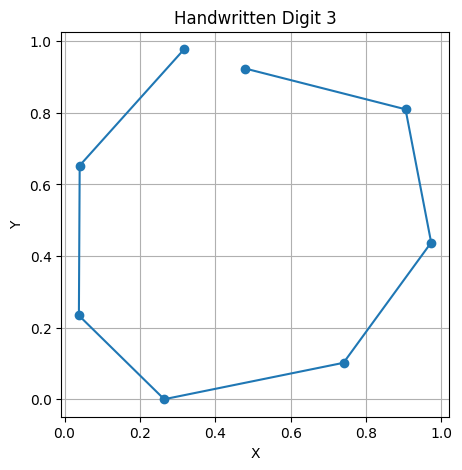

y = [1. 0.]


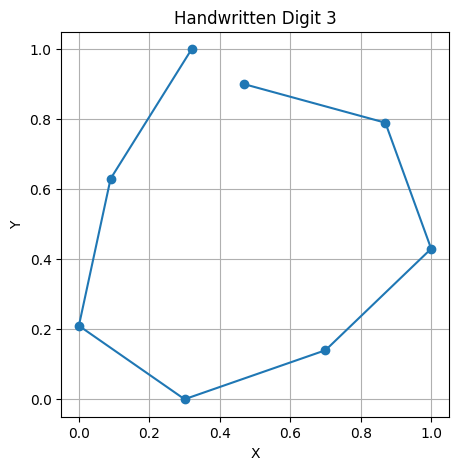

In [19]:
idx = 0
sample = X_test[idx:idx+1]
sample_label = y_test[idx:idx+1]
autoencoded_sample = autoencoder.predict(sample)
visualise_decoded_digit(autoencoded_sample,sample_label)
visualise_digit(X_test,y_test,idx)

#Getting weights for LatentCF

In [ ]:
#Gettting the Global weights, needed for counterfactuals

from _guided import get_global_weights
from help_functions import evaluate
pos_label = 1
neg_label = 0

step_weights = get_global_weights(
        X,
        y_classes,
        cnnClassifier,
        n_timesteps= n_timesteps,
        n_features=n_features,
        random_state=RANDOM_STATE,
)


In [34]:
import warnings

import numpy as np
import tensorflow as tf
from tensorflow import keras

from wildboar.explain import IntervalImportance
#from LIMESegment.Utils.explanations import LIMESegment


class ModifiedLatentCF_trial:
    """Explanations by generating a counterfacutal sample in the latent space of
    any autoencoder.

    References
    ----------
    Learning Time Series Counterfactuals via Latent Space Representations,
    Wang, Z., Samsten, I., Mochaourab, R., Papapetrou, P., 2021.
    in: International Conference on Discovery Science, pp. 369–384. https://doi.org/10.1007/978-3-030-88942-5_29
    """

    def __init__(
        self,
        probability=0.5,
        *,
        tolerance=1e-6,
        max_iter=100,
        optimizer=None,
        autoencoder=None,
        pred_margin_weight=1.0,  # weighted_steps_weight = 1 - pred_margin_weight
        step_weights="local",
        random_state=None,
        max_weighted_steps_loss= 0.002
    ):
        """
        Parameters
        ----------
        probability : float, optional
            The desired probability assigned by the model

        tolerance : float, optional
            The maximum difference between the desired and assigned probability

        optimizer :
            Optimizer with a defined learning rate

        max_iter : int, optional
            The maximum number of iterations

        autoencoder : int, optional
            The autoencoder for the latent representation

            - if None the sample is generated in the original space
            - if given, the autoencoder is expected to have `k` decoder layer and `k`
              encoding layers.
        """
        self.optimizer_ = (
            tf.optimizers.Adam(learning_rate=1e-4) if optimizer is None else optimizer
        )
        self.mse_loss_ = keras.losses.MeanSquaredError()
        self.probability_ = tf.constant([probability])
        self.tolerance_ = tf.constant(tolerance)
        self.max_iter = max_iter
        self.autoencoder = autoencoder
        self.max_weighted_steps_loss = max_weighted_steps_loss

        # Weights of the different loss components
        self.pred_margin_weight = pred_margin_weight
        self.weighted_steps_weight = 1 - self.pred_margin_weight

        self.step_weights = step_weights
        self.random_state = random_state

    def fit(self, model):
        """Fit a new counterfactual explainer to the model

        Paramaters
        ----------

        model : keras.Model
            The model
        """
        if self.autoencoder:
            (
                encode_input,
                encode_output,
                decode_input,
                decode_output,
            ) = extract_encoder_decoder(self.autoencoder)
            self.decoder_ = keras.Model(inputs=decode_input, outputs=decode_output)
            self.encoder_ = keras.Model(inputs=encode_input, outputs=encode_output)
        else:
            self.decoder_ = None
            self.encoder_ = None
        self.model_ = model
        return self

    def predict(self, x):
        """Compute the difference between the desired and actual probability

        Parameters
        ---------
        x : Variable
            Variable of the sample
        """
        if self.autoencoder is None:
            z = x
        else:
            z = self.decoder_(x)

        return self.model_(z)

    # The "pred_margin_loss" is designed to measure the prediction probability to the desired decision boundary
    def pred_margin_mse(self, prediction):
        return self.mse_loss_(self.probability_, prediction)

    # An auxiliary MAE loss function to measure the proximity with step_weights
    def weighted_mae(self, original_sample, cf_sample, step_weights):
        return tf.math.reduce_mean(
            tf.math.multiply(tf.math.abs(original_sample - cf_sample), step_weights)
        )

    # An auxiliary normalized L2 loss function to measure the proximity with step_weights
    def weighted_normalized_l2(self, example, cf_sample, step_weights):
        var_diff = tf.math.reduce_variance(example - cf_sample)
        var_orig = tf.math.reduce_variance(example)
        var_cf = tf.math.reduce_variance(cf_sample)

        normalized_l2 = 0.5 * var_diff / (var_orig + var_cf)
        return tf.math.reduce_mean(
            tf.math.multiply(
                normalized_l2,
                step_weights,
            )
        )
    def euclidian_distance(self,x,y):
      euclidean_distance = np.linalg.norm(x - y)
      return(euclidean_distance)


    # additional input of step_weights
    def compute_loss(self, example, z_search, step_weights, target_label):
        loss = tf.zeros(shape=())
        decoded = self.decoder_(z_search) if self.autoencoder is not None else z_search
        pred = self.model_(decoded)[:, target_label]

        pred_margin_loss = self.pred_margin_mse(pred)
        loss += self.pred_margin_weight * pred_margin_loss

        # euclidian_distance=self.euclidian_distance(decoded,self.example)

        # weighted_steps_loss = self.weighted_mae(
        #     original_sample=tf.cast(self.example, dtype=tf.float32),
        #     cf_sample=tf.cast(decoded, dtype=tf.float32),
        #     step_weights=tf.cast(step_weights, tf.float32),
        # )
        weighted_steps_loss = self.weighted_normalized_l2(
            example=tf.cast(example, dtype=tf.float32),
            cf_sample=tf.cast(decoded, dtype=tf.float32),
            step_weights=tf.cast(step_weights, tf.float32)
        )
        loss += self.weighted_steps_weight * weighted_steps_loss

        return loss, pred_margin_loss, weighted_steps_loss

    def get_closesed_counterfactual(self, X, X_ofOpp,step_weights):
      best_example = X_ofOpp[0][np.newaxis]
      min_distance = self.weighted_normalized_l2(X_ofOpp[0][np.newaxis],X,step_weights)
      for idx in range(X_ofOpp.shape[0]):
        sample =X_ofOpp[idx][np.newaxis]
        distance = self.weighted_normalized_l2(sample,X,step_weights)
        if distance < min_distance:
          min_distance = distance
          best_example = sample
      return best_example

    # TODO: compatible with the counterfactuals of wildboar
    #       i.e., define the desired output target per label
    def transform(self, x, pred_labels,X_ofOpp):
        """Generate counterfactual explanations

        x : array-like of shape [n_samples, n_timestep, n_dims]
            The samples
        """

        result_samples = np.empty(x.shape)
        losses = np.empty(x.shape[0])
        # `weights_all` needed for debugging
        weights_all = np.empty((x.shape[0], 1, x.shape[1], x.shape[2]))

        for i in range(x.shape[0]):
            if i % 25 == 0:
                print(f"{i+1} samples been transformed.")



            # if self.step_weights == "global" OR "uniform"
            if isinstance(self.step_weights, np.ndarray):  #  "global" OR "uniform"
                step_weights = self.step_weights
            elif self.step_weights == "local":
                # ignore warning of matrix multiplication, from LIMESegment: `https://stackoverflow.com/questions/29688168/mean-nanmean-and-warning-mean-of-empty-slice`
                # ignore warning of scipy package warning, from LIMESegment: `https://github.com/paulvangentcom/heartrate_analysis_python/issues/31`
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=RuntimeWarning)
                    warnings.simplefilter("ignore", category=UserWarning)
                    step_weights = get_local_weights(
                        x[i],
                        self.model_,
                        random_state=self.random_state,
                        pred_label=pred_labels[i],
                    )
            else:
                raise NotImplementedError(
                    "step_weights not implemented, please choose 'local', 'global' or 'uniform'."
                )

            example = self.get_closesed_counterfactual(x[np.newaxis, i], X_ofOpp, step_weights)
            #visualise_decoded_digit(x[np.newaxis, i],0)
            #visualise_decoded_digit(example,1)
            x_sample, loss = self._transform_sample(
                x[np.newaxis, i], step_weights, pred_labels[i],example
            )

            result_samples[i] = x_sample
            losses[i] = loss
            weights_all[i] = step_weights

        print(f"{i+1} samples been transformed, in total.")

        return result_samples, losses, weights_all

    def _transform_sample(self, x, step_weights, pred_label,example):
        """Generate counterfactual explanations

        x : array-like of shape [n_samples, n_timestep, n_dims]
            The samples
        """
        # TODO: check_is_fitted(self)
        if self.autoencoder is not None:
            z = tf.Variable(self.encoder_(x))
        else:
            z = tf.Variable(x, dtype=tf.float32)

        it = 0
        target_label = 1 - pred_label  # for binary classification

        with tf.GradientTape() as tape:
            loss, pred_margin_loss, weighted_steps_loss = self.compute_loss(
                example, z, step_weights, target_label
            )

        if self.autoencoder is not None:
            pred = self.model_(self.decoder_(z))
        else:
            pred = self.model_(z)

        # # uncomment for debug
        # print(
        #     f"current loss: {loss}, pred_margin_loss: {pred_margin_loss}, weighted_steps_loss: {weighted_steps_loss}, pred prob:{pred}, iter: {it}."
        # )

        # TODO: modify the loss to check both validity and proximity; how to design the condition here?
        # while (pred_margin_loss > self.tolerance_ or pred[:, 1] < self.probability_ or weighted_steps_loss > self.step_tolerance_)?
        # loss > tf.multiply(self.tolerance_rate_, loss_original)
        #
        while (
            pred_margin_loss > self.tolerance_
            and weighted_steps_loss > self.max_weighted_steps_loss
        ) and (it < self.max_iter if self.max_iter else True):
            # Get gradients of loss wrt the sample
            grads = tape.gradient(loss, z)
            # Update the weights of the sample
            self.optimizer_.apply_gradients([(grads, z)])

            with tf.GradientTape() as tape:
                loss, pred_margin_loss, weighted_steps_loss = self.compute_loss(
                    example, z, step_weights, target_label
                )
            it += 1

            if self.autoencoder is not None:
                pred = self.model_(self.decoder_(z))
            else:
                pred = self.model_(z)

        # # uncomment for debug
        # print(
        #     f"current loss: {loss}, pred_margin_loss: {pred_margin_loss}, weighted_steps_loss: {weighted_steps_loss}, pred prob:{pred}, iter: {it}. \n"
        # )

        res = z.numpy() if self.autoencoder is None else self.decoder_(z).numpy()
        return res, float(loss)


def extract_encoder_decoder(autoencoder):
    """Extract the encoder and decoder from an autoencoder

    autoencoder : keras.Model
        The autoencoder of `k` encoders and `k` decoders
    """
    depth = len(autoencoder.layers) // 2
    encoder = autoencoder.layers[1](autoencoder.input)
    for i in range(2, depth):
        encoder = autoencoder.layers[i](encoder)

    encode_input = keras.Input(shape=encoder.shape[1:])
    decoder = autoencoder.layers[depth](encode_input)
    for i in range(depth + 1, len(autoencoder.layers)):
        decoder = autoencoder.layers[i](decoder)

    return autoencoder.input, encoder, encode_input, decoder

In [ ]:
reset_seeds()
cf_model = ModifiedLatentCF_trial(
    probability=0.9,tolerance=1e-6, max_iter=500, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),autoencoder = autoencoder,
    pred_margin_weight=0.5, step_weights = step_weights, random_state= RANDOM_STATE, max_weighted_steps_loss= 0.01)
cf_model.fit(cnnClassifier)

y_neg = y_train_classes[y_train_classes == 0]
X_neg = X_train[y_train_classes == 0]


with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning) # ignore warning of matrix multiplication: https://stackoverflow.com/questions/29688168/mean-nanmean-and-warning-mean-of-empty-slice
    cf_embeddings, losses, weights = cf_model.transform(X_neg, y_neg, X_train[y_train_classes == 1],) # x, pred_label, X_OppClass
z_pred = cnnClassifier.predict(cf_embeddings)
cf_pred_labels = np.argmax(z_pred, axis=1)

#evaluate_res = evaluate(X_pred_neg, best_cf_samples, z_pred, n_timesteps, tree, max_distance)
#evaluate_res #  proximity, validity, cost_mean, cost_std

print(f'Transformation_finished with validity_score = {validity_score(y_neg,cf_pred_labels)}')

actual
y = 0


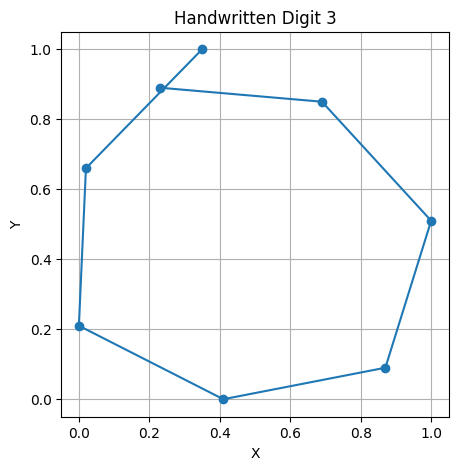

counterfactual
y = 0


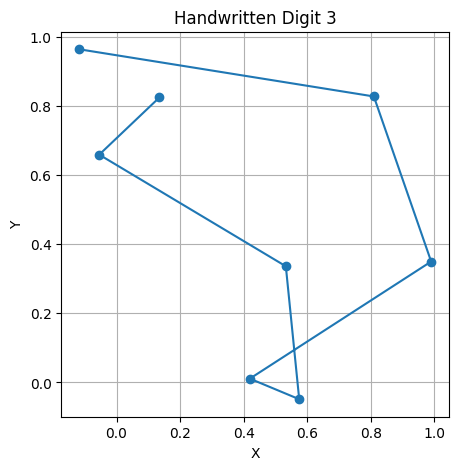

actual
y = 0


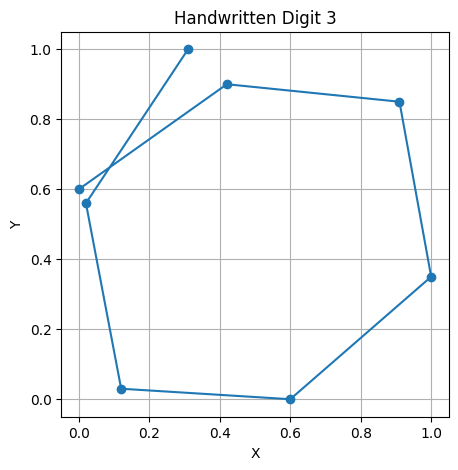

counterfactual
y = 0


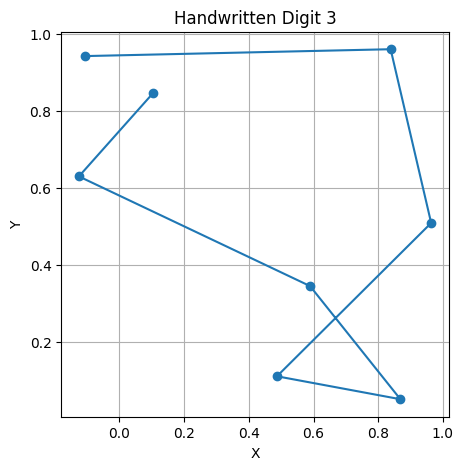

actual
y = 0


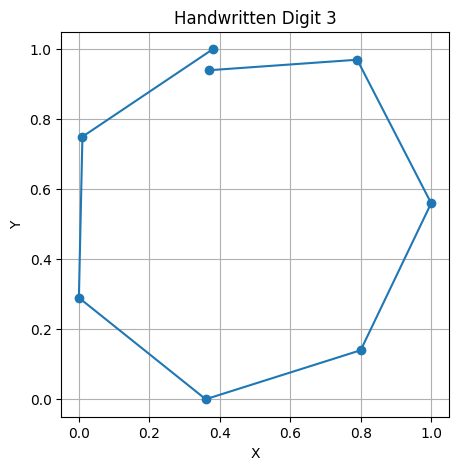

counterfactual
y = 0


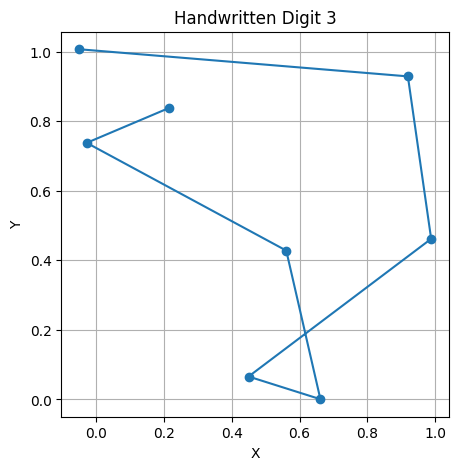

actual
y = 0


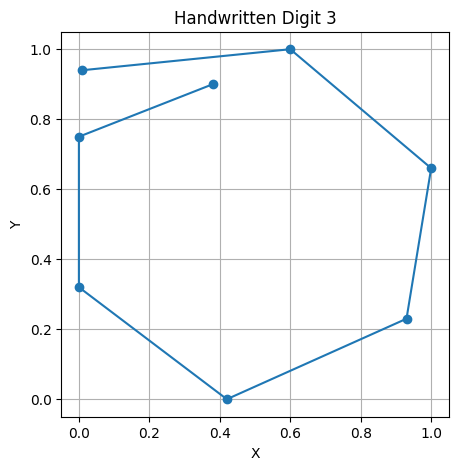

counterfactual
y = 0


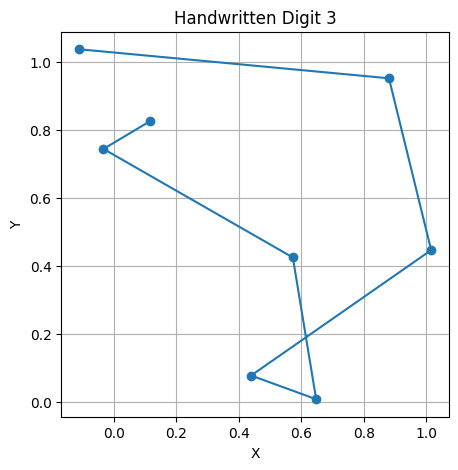

actual
y = 0


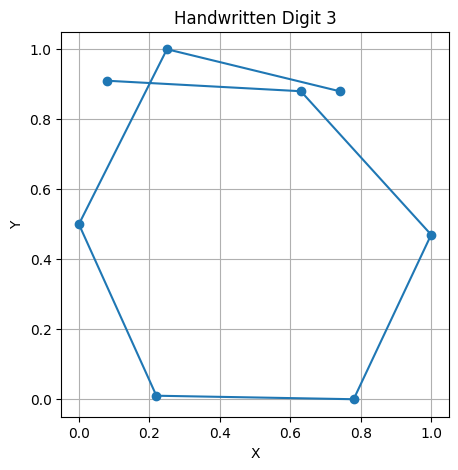

counterfactual
y = 0


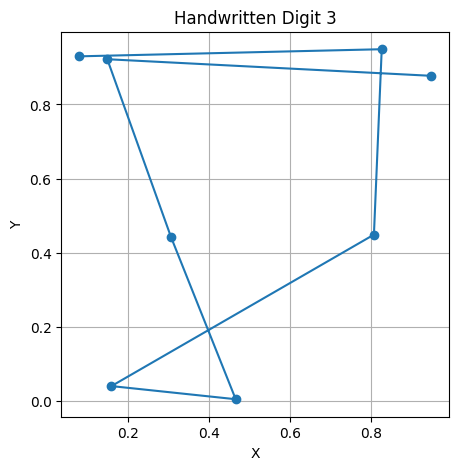

actual
y = 0


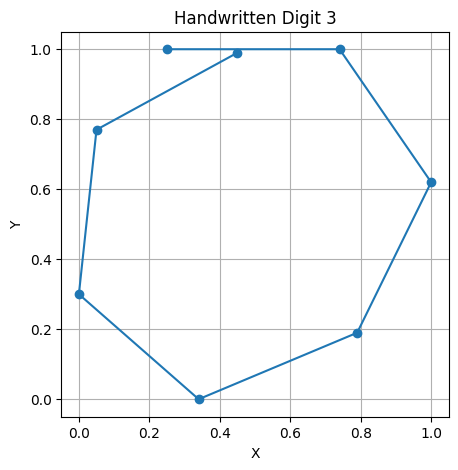

counterfactual
y = 0


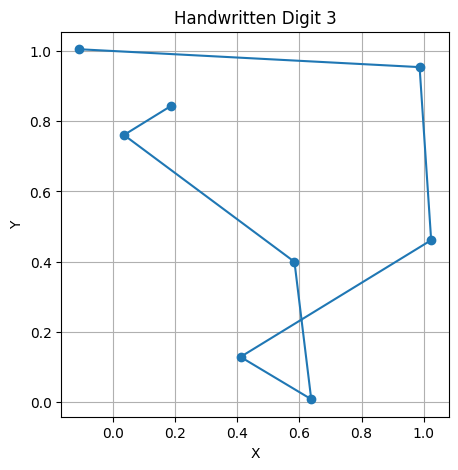

In [38]:
for i in range(6):
   i=i+30
   print("actual")
   visualise_digit(X_neg,y_neg,i,figsize = (5,5))
   print("counterfactual")
   visualise_digit(cf_embeddings,y_neg,i,figsize = (5,5))


In [39]:
#Validity
cf_pred = cnnClassifier.predict(cf_embeddings)[:, 1] # predicted probabilities of CFs
cf_pred_labels = cf_pred
for idx in range(cf_pred_labels.shape[0]):
  if cf_pred_labels[idx] > 0.5:
    cf_pred_labels[idx] = 1
  else:
    cf_pred_labels[idx] = 0


print(f'Transformation_finished with validity_score = {validity_score(y_neg,cf_pred_labels)}')

23/23 [==============================] - 0s 2ms/step
Transformation_finished with validity_score = 0.9754098360655737


In [ ]:
#Calculating proximity withour absolute
from tensorflow.keras.losses import MeanSquaredError
total_mse = 0
probability = 0.9
for idx in range(cf_embeddings.shape[0]):
    counterfactual = cf_embeddings[idx,np.newaxis]
    prediction = cnnClassifier.predict(counterfactual)[:, 1]
    mse = MeanSquaredError()
    mse_dist = mse(probability, prediction).numpy()
    total_mse +=mse_dist
mean_mse = total_mse /cf_embeddings.shape[0]


In [41]:
print(f"The Mean MSE of the data is: {mean_mse} ")

The Mean MSE of the data is: 0.023704771866787707 


In [ ]:
#Calculating proximity with absolute
from tensorflow.keras.losses import MeanSquaredError
total = 0
probability = 0.9
for idx in range(cf_embeddings.shape[0]):
    counterfactual = cf_embeddings[idx,np.newaxis]
    prediction = cnnClassifier.predict(counterfactual)[:, 1]
    dist = abs(prediction - probability)
    total +=dist
mean_mse = total /cf_embeddings.shape[0]

In [43]:
print(f"The Mean MSE of the data is: {mean_mse} ")

The Mean MSE of the data is: [0.09199689] 


In [44]:
#Proximity
def euclidean_distance(X, cf_samples):
    paired_distances = np.linalg.norm(X - cf_samples, axis=1)
    return np.mean(paired_distances)
euclidean_distance(X_neg, cf_embeddings)

0.631205640628796

In [45]:
from scipy.stats import gaussian_kde

diffrences_from_abnormal = []
diffrences_from_normal = []
for dimention in range(cf_embeddings.shape[2]):


  abnormal_data = X[y_classes == 1][:,:,dimention]
  normal_data = X[y_classes == 0][:,:,dimention]
  counterf_data = cf_embeddings[:,:,dimention]

  #get the kernel for every dimention of the trained
  kernel = gaussian_kde(abnormal_data.T,bw_method=None)

  #get all the log likelihoods
  log_likelihood_abnormal = np.mean(kernel.logpdf(abnormal_data.T))
  log_likelihood_normal = np.mean(kernel.logpdf(normal_data.T))
  log_likelihood_counterfactual = np.mean(kernel.logpdf(counterf_data.T))

  #get the diffrences from the counterfactuals
  diff_from_abnormal = abs(log_likelihood_counterfactual-log_likelihood_abnormal)
  diffrences_from_abnormal.append(diff_from_abnormal)

  diff_from_normal = abs(log_likelihood_counterfactual-log_likelihood_normal)
  diffrences_from_normal.append(diff_from_normal)


In [46]:
diffrences_from_normal

[3.859824647652445, 3.6869255432355224]

In [47]:
diffrences_from_abnormal

[4.308036225190443, 4.27822514834897]